# <b><center>Modelo de Regresión Logística</b></center>

## **Librerías**

In [138]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    matthews_corrcoef,
    cohen_kappa_score,
    fbeta_score,
    log_loss,
    brier_score_loss,
    precision_score,
    recall_score,
    confusion_matrix,
    make_scorer, 
    cohen_kappa_score,
    classification_report,
    roc_curve, 
    auc,
    precision_recall_curve, 
    average_precision_score,
    f1_score
)
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.api import Logit
from scipy import stats
from statsmodels.formula.api import logit
from statsmodels.stats.stattools import durbin_watson
from statsmodels.sandbox.stats.runs import runstest_1samp
import joblib

## **Datos**

In [3]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

X_train = df_train.drop('Has_Hypertension', axis=1)
y_train = df_train['Has_Hypertension']

X_test = df_test.drop('Has_Hypertension', axis=1)
y_test = df_test['Has_Hypertension']

## **Supuestos**

### Independencia de observaciones

In [134]:
X = X_train.select_dtypes(include=np.number)
y = y_train.astype(int)
X = sm.add_constant(X)
model = Logit(y, X).fit(disp=False)

pred_probs = model.predict(X)
residuals_pearson = (y - pred_probs) / np.sqrt(pred_probs * (1 - pred_probs))
runs_z, runs_pvalue = runstest_1samp(residuals_pearson, correction=True)

print(f"Estadístico Z de la prueba de rachas: {runs_z:.4f}")
print(f"p-valor de la prueba: {runs_pvalue:.4f}")

if runs_pvalue < 0.05:
    print("Se rechaza la hipótesis de independencia de observaciones.")
else:
    print("No se rechaza la hipótesis de independencia. Observaciones independientes.")

Estadístico Z de la prueba de rachas: 0.4784
p-valor de la prueba: 0.6323
No se rechaza la hipótesis de independencia. Observaciones independientes.


### No multicolinealidad severa

In [132]:
X_vif = X_train.select_dtypes(include=[np.number]).copy()
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print(vif_data)
print("\n\n"
    "Todos los valores de VIF están por debajo del umbral común de 5, lo que indica que no existe multicolinealidad severa entre las variables independientes.\n"
    "VIF máximo observado: const = 4.46 (esperado por ser la constante).\n"
    "VIFs de las variables restantes oscilan entre ~1.00 y ~1.01, lo que indica baja correlación entre predictores.\n"
    "Con base en este análisis, no es necesario eliminar variables por multicolinealidad."
)

         Variable       VIF
0           const  4.462542
1             Age  1.001498
2     Salt_Intake  1.004482
3    Stress_Score  1.007177
4      BP_History  1.007324
5  Sleep_Duration  1.005632
6             BMI  1.003996
7  Family_History  1.003759
8  Exercise_Level  1.004201
9  Smoking_Status  1.001982


Todos los valores de VIF están por debajo del umbral común de 5, lo que indica que no existe multicolinealidad severa entre las variables independientes.
VIF máximo observado: const = 4.46 (esperado por ser la constante).
VIFs de las variables restantes oscilan entre ~1.00 y ~1.01, lo que indica baja correlación entre predictores.
Con base en este análisis, no es necesario eliminar variables por multicolinealidad.


### Linealidad del logit

In [135]:
X_bt = X_train[[col for col in X_train.columns if X_train[col].nunique() > 10]]
X_bt = X_bt.select_dtypes(include=[np.number]).copy()
X_bt['y'] = y_train.values
log_cols = []
for col in X_bt.columns.difference(['y']):
    X_bt[f'log_{col}'] = X_bt[col] * np.log(np.where(X_bt[col] > 0, X_bt[col], np.nan))
    log_cols.append(f'log_{col}')

X_bt_clean = X_bt.dropna()
predictors = ' + '.join(X_bt_clean.columns.difference(['y']))
formula = f'y ~ {predictors}'
model = logit(formula, data=X_bt_clean).fit()
pval_box_tidwell = model.pvalues.reindex(log_cols)
print("P-valores de la prueba de linealidad (Box-Tidwell):")
print(pval_box_tidwell)
print("\nTodas las variables numéricas evaluadas (Age, BMI, Salt_Intake, Sleep_Duration, Stress_Score) \ncumplen con el supuesto de linealidad en el logit, por lo que pueden usarse directamente en la \nregresión logística sin preocuparte de transformar su forma funcional.")

Optimization terminated successfully.
         Current function value: 0.214841
         Iterations 10
P-valores de la prueba de linealidad (Box-Tidwell):
log_Age               0.302244
log_BMI               0.127547
log_Salt_Intake       0.290509
log_Sleep_Duration    0.607876
log_Stress_Score      0.420441
dtype: float64

Todas las variables numéricas evaluadas (Age, BMI, Salt_Intake, Sleep_Duration, Stress_Score) 
cumplen con el supuesto de linealidad en el logit, por lo que pueden usarse directamente en la 
regresión logística sin preocuparte de transformar su forma funcional.


### Ausencia de outliers influyentes

In [122]:
X_sm = sm.add_constant(X_train.select_dtypes(include=[np.number]))
logit_model = Logit(y_train, X_sm).fit(disp=0)
influence = logit_model.get_influence()
cooks_d = influence.cooks_distance[0]
threshold = 4 / X_sm.shape[0]
influential_points = np.where(cooks_d > threshold)[0]
print(f"Observaciones influyentes: {len(influential_points)} / {X_sm.shape[0]}, no son muchos valores atípicos, representan solo el {(len(influential_points)/X_sm.shape[0])*100:.4f}% de los datos")

Observaciones influyentes: 130 / 1488, no son muchos valores atípicos, representan solo el 8.7366% de los datos


### Tamaño muestral suficiente

In [119]:
n = X_train.shape[0]
k = X_train.shape[1]
print(f"Observaciones por predictor: {n / k:.1f}, lo cual es mayor de los mínimo necesario que es 10 o 20 datos por variable")

Observaciones por predictor: 114.5, lo cual es mayor de los mínimo necesario que es 10 o 20 datos por variable


## **Evaluación del Modelo**

In [144]:
X = X_train.copy()
X = X.astype({col: int for col in X.select_dtypes(include='bool').columns})
y = y_train.copy()
X = X.apply(pd.to_numeric)
y = pd.to_numeric(y)
X_stats = sm.add_constant(X)
mod_stats = sm.Logit(y, X_stats).fit(disp=0)

### Pseudo R2

In [156]:
llf_model = mod_stats.llf
llf_null = mod_stats.llnull
n = mod_stats.nobs

# McFadden
r2_mcfadden = 1 - (llf_model / llf_null)

# Cox & Snell
r2_cox_snell = 1 - np.exp((2 / n) * (llf_null - llf_model))

# Nagelkerke corregido
denom = 1 - np.exp((2 / n) * llf_null)
r2_nagelkerke = r2_cox_snell / denom if denom != 0 else np.nan

# Devianza
dev_model = -2 * llf_model
dev_null = -2 * llf_null
r2_devianza = 1 - (dev_model / dev_null)

print("Pseudo R²:")
print(f"  - Cox & Snell     : {r2_cox_snell:.4f}")
print(f"  - Nagelkerke      : {r2_nagelkerke:.4f}")
print(f"  - McFadden        : {r2_mcfadden:.4f}")
print(f"  - Basado en devianza: {r2_devianza:.4f}")

Pseudo R²:
  - Cox & Snell     : 0.4936
  - Nagelkerke      : 0.6585
  - McFadden        : 0.4914
  - Basado en devianza: 0.4914


El pseudo R² de **Cox & Snell (0.4936)** sugiere que el modelo explica cerca del 49% de la variabilidad en los datos, aunque está limitado por no alcanzar un máximo de 1. El **Nagelkerke R² (0.6585)**, que ajusta esta limitación, indica que el modelo tiene una capacidad explicativa alta, cercana al 66%, en una escala comparable al R² clásico. El **McFadden R² (0.4914)**, considerado más conservador, también refleja un ajuste fuerte, pues valores entre 0.2 y 0.4 ya se consideran razonables. Finalmente, el R² basado en devianza coincide con McFadden, lo que reafirma la consistencia del ajuste. En conjunto, los indicadores sugieren que el modelo logra capturar patrones relevantes sin sobreajuste, siendo estadísticamente sólido y confiable para propósitos explicativos y predictivos.

### Estadístico de verosimilitud

In [158]:
lr_stat = 2 * (ll_model - ll_null)
df_lr = mod_stats.df_model
p_value_lr = chi2.sf(lr_stat, df_lr)
print('P-valor: ', p_value_lr)

P-valor:  3.514177122351216e-208


La prueba de verosimilitud (Likelihood Ratio Test) contrasta las siguientes hipótesis:

- **H₀ (hipótesis nula):** el modelo completo no mejora significativamente el ajuste comparado con el modelo nulo (sin predictores).
- **H₁ (hipótesis alterna):** el modelo completo mejora significativamente el ajuste respecto al modelo nulo.

Dado que el **p-valor = 3.51e-208** es prácticamente cero, se rechaza contundentemente la hipótesis nula. Esto indica que al incorporar los predictores, el modelo logra un ajuste estadísticamente superior al del modelo vacío, justificando su complejidad y validando su utilidad.

### Desviancia residual 

In [159]:
devianza = -2 * ll_model
print('Desviancia Modelo con Predictores: ', devianza)
print('Desviancia Modelo Nulo: ', dev_null)

Desviancia Modelo con Predictores:  1047.8295826177807
Desviancia Modelo Nulo:  2060.385998472594


La **desviancia del modelo con predictores** (1047.83) es considerablemente menor que la **desviancia del modelo nulo** (2060.39), lo que indica que el modelo con variables explicativas mejora notablemente el ajuste respecto al modelo sin predictores. Esta reducción sustancial en la desviancia sugiere que las variables incluidas aportan información significativa para explicar la respuesta. Además, esta diferencia es la base del test de verosimilitud, cuyo valor-p extremadamente bajo confirma la superioridad del modelo completo sobre el modelo nulo.

### AIC y BIC

In [160]:
X_null = np.ones((n, 1))
mod_null = sm.Logit(y, X_null).fit(disp=0)
aic_null = mod_null.aic
bic_null = mod_null.bic

aic = mod_stats.aic
bic = mod_stats.bic
print('AIC del modelo con predictores: ', aic)
print('AIC del modelo nulo: ', aic_null)
print('BIC del modelo con predictores: ', bic)
print('BIC del modelo nulo: ', bic_null)

AIC del modelo con predictores:  1075.8295826177807
AIC del modelo nulo:  2062.385998471855
BIC del modelo con predictores:  1150.1022176332833
BIC del modelo nulo:  2067.6911866872483


- **AIC (Criterio de Información de Akaike):**
  - Modelo con predictores: **1075.83**
  - Modelo nulo (solo la media): **2062.39**
  - ➤ El modelo con predictores tiene un AIC **mucho menor**, lo que sugiere que ofrece un **mejor equilibrio entre ajuste y complejidad**. El descenso drástico indica una mejora sustancial al incluir variables explicativas.

- **BIC (Criterio de Información Bayesiano):**
  - Modelo con predictores: **1150.10**
  - Modelo nulo: **2067.69**
  - ➤ Aunque el BIC penaliza más fuertemente la complejidad del modelo, **también favorece claramente** el modelo con predictores. Esto refuerza que **la mejora en ajuste es suficientemente grande** como para justificar la inclusión de las variables.

**Conclusión**: Tanto AIC como BIC indican de forma contundente que el modelo con predictores es **muy superior** al modelo nulo. Es decir, las variables independientes utilizadas aportan **información real y útil** para predecir la presencia de hipertensión.

### Coeficientes, odds ratio, IC, p-valores

In [150]:
params = mod_stats.params
conf = mod_stats.conf_int()
odds_ratios = np.exp(params)
conf_odds = np.exp(conf)
odds_table = pd.DataFrame({
    "Coeficiente": params,
    "Odds Ratio": odds_ratios,
    "CI 2.5%": conf_odds[0],
    "CI 97.5%": conf_odds[1],
    "p-valor": mod_stats.pvalues
})
pd.set_option("display.width", 200)
pd.set_option("display.max_columns", 10)
print(odds_table)

                          Coeficiente  Odds Ratio   CI 2.5%   CI 97.5%       p-valor
const                       -3.830049    0.021709  0.012241   0.038500  3.205114e-39
Age                          1.735829    5.673629  4.208822   7.648237  4.585995e-30
Salt_Intake                  0.784650    2.191639  1.767673   2.717291  8.463514e-13
Stress_Score                 1.866068    6.462837  4.623577   9.033755  9.152385e-28
BP_History                   2.287119    9.846532  7.626954  12.712047  6.005382e-69
Sleep_Duration              -0.885171    0.412644  0.328342   0.518590  3.159533e-14
BMI                          0.834011    2.302535  1.848065   2.868767  1.049813e-13
Family_History               2.309259   10.066964  7.062642  14.349271  2.423243e-37
Exercise_Level               0.111115    1.117524  0.918055   1.360333  2.680068e-01
Smoking_Status               2.476844   11.903633  7.929465  17.869614  6.542701e-33
Medication_Beta Blocker     -0.148219    0.862242  0.518757   1.4

En este modelo, la variable objetivo es la presencia de hipertensión (1 = tiene hipertensión, 0 = no la tiene). Todos los coeficientes se interpretan en función de cómo modifican la **log-odds** de tener hipertensión, y los **odds ratios (OR)** indican cuánto se multiplican las probabilidades al aumentar una unidad en cada predictor. 

* **Significancia estadística**

Los **p-valores individuales** nos permiten evaluar si el efecto de cada predictor sobre la hipertensión es estadísticamente distinto de cero. En este caso, la mayoría de las variables tienen **p-valores extremadamente pequeños (<< 0.05)**, lo que indica una fuerte evidencia estadística de que influyen significativamente en la presencia de hipertensión. Solo unas pocas variables no son significativas (por ejemplo, `Exercise_Level`, `Medication_Beta Blocker`, `Medication_Diuretic`, `Medication_Other`, `Medication_Not specified`), lo que sugiere que, bajo este modelo, **no se asocian estadísticamente con cambios en la probabilidad de hipertensión**.

* **Variables más influyentes**

    - **Smoking_Status (Coef: 2.47, OR ≈ 11.90)**  
      Fumar se asocia con un incremento de casi **12 veces** en las probabilidades de tener hipertensión. Este es uno de los factores de riesgo más potentes del modelo.  
      ➤ *Interpretación:* los fumadores tienen una probabilidad de hipertensión mucho mayor que los no fumadores, incluso controlando por otras variables.
    
    - **Family_History (Coef: 2.31, OR ≈ 10.07)**  
      Tener antecedentes familiares de hipertensión multiplica por **10** las probabilidades de padecerla.  
      ➤ *Interpretación:* la carga genética o ambiente familiar relacionado juega un papel crucial.
    
    - **BP_History (Coef: 2.29, OR ≈ 9.85)**  
      Una historia previa de presión arterial elevada casi **multiplica por 10** la probabilidad de tener hipertensión actual.  
      ➤ *Interpretación:* es un predictor clínico muy fuerte, como era de esperarse.
    
    - **Stress_Score (Coef: 1.87, OR ≈ 6.46)**  
      Por cada unidad adicional en el puntaje de estrés, las probabilidades aumentan más de **6 veces**.  
      ➤ *Interpretación:* el estrés tiene un efecto significativo sobre la hipertensión, posiblemente relacionado con la activación constante del sistema nervioso simpático.
    
    - **Age (Coef: 1.73, OR ≈ 5.67)**  
      Por cada año o unidad adicional en edad, la probabilidad de hipertensión se **multiplica por 5.67**.  
      ➤ *Interpretación:* la edad es un factor fisiológico natural que incrementa el riesgo de hipertensión.
    
    - **BMI (Coef: 0.83, OR ≈ 2.30)**  
      Cada unidad adicional en el índice de masa corporal **dobla** las probabilidades de hipertensión.  
      ➤ *Interpretación:* el sobrepeso/obesidad es un factor crítico modificable.
    
    - **Salt_Intake (Coef: 0.78, OR ≈ 2.19)**  
      Un aumento en el consumo de sal incrementa la probabilidad de hipertensión en **más del doble**.  
      ➤ *Interpretación:* refuerza la recomendación de controlar la ingesta de sodio como medida preventiva.

* **Factores protectores**

    - **Sleep_Duration (Coef: -0.88, OR ≈ 0.41)**  
      A diferencia de las demás, esta variable tiene un **coeficiente negativo**, lo cual indica un efecto protector. Por cada hora adicional de sueño, las probabilidades de hipertensión **se reducen un 59%**.  
      ➤ *Interpretación:* dormir más se asocia con menor riesgo de hipertensión, posiblemente por su relación con menor estrés y mejor regulación hormonal.

* **Variables no significativas (p > 0.05)**

    - **Exercise_Level**
    - **Medication_Beta Blocker**
    - **Medication_Diuretic**
    - **Medication_Other**
    - **Medication_Not specified**

    Esto **no significa que no tengan ningún efecto clínico**, sino que en este conjunto de datos y controlando por las otras variables, su relación con la hipertensión no es estadísticamente significativa.

* **Conclusión general**

El modelo revela que **edad, antecedentes familiares, tabaquismo, estrés, historial de presión arterial alta, IMC y consumo de sal** son los principales factores de riesgo de hipertensión, con efectos estadísticamente significativos y clínicamente relevantes. También se observa un efecto protector del sueño. Esta información permite orientar intervenciones preventivas y clínicas hacia los factores más determinantes.

## **Modelo en producción**

In [4]:
mod_rl = LogisticRegression()
mod_rl.fit(X_train, y_train)
y_pred = mod_rl.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       239
           1       0.82      0.81      0.82       258

    accuracy                           0.81       497
   macro avg       0.81      0.81      0.81       497
weighted avg       0.81      0.81      0.81       497



El modelo con sus valores base tiene muy buenas métricas, sin embargo, aún podemos mejorarlo un poco más.

## **Tunning del Modelo**

In [21]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

combinaciones_validas = [
    "l1__liblinear",
    "l1__saga",
    "l2__lbfgs",
    "l2__liblinear",
    "l2__saga",
    "l2__newton-cg",
    "elasticnet__saga",
    "none__lbfgs",
    "none__saga",
    "none__newton-cg"
]

kappa_scorer = make_scorer(cohen_kappa_score)

def objective(trial):
    combo = trial.suggest_categorical("penalty_solver", combinaciones_validas)
    penalty_str, solver = combo.split("__")
    penalty = None if penalty_str == "none" else penalty_str
    
    params = {
        "penalty": penalty,
        "solver": solver,
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "random_state": 42
    }

    if penalty is not None:
        params["C"] = trial.suggest_float("C", 1e-4, 10.0, log=True)
    if penalty == "elasticnet":
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)

    model = LogisticRegression(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=kappa_scorer)
    return score.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
print("📈 Mejor precisión:", study.best_value)
print("🔧 Mejores hiperparámetros:")
print(study.best_params)

📈 Mejor precisión: 0.6607855679168221
🔧 Mejores hiperparámetros:
{'penalty_solver': 'l2__saga', 'max_iter': 483, 'C': 0.3399800882410404}


## **Modelo Tuneado**

In [39]:
mod_rl = LogisticRegression(penalty='l2', solver='saga', max_iter=919, C=0.2937620602817099)
mod_rl.fit(X_train, y_train)
y_pred = mod_rl.predict(X_test)
y_proba = mod_rl.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       239
           1       0.83      0.82      0.82       258

    accuracy                           0.82       497
   macro avg       0.82      0.82      0.82       497
weighted avg       0.82      0.82      0.82       497



## **Métricas de Evaluación**

### Matthews Correlation Coefficient (MCC)

In [23]:
mcc = matthews_corrcoef(y_test, y_pred)
print('MCC: ', mcc)

MCC:  0.6334825237105253


### Cohen’s Kappa

In [24]:
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa: ', kappa)

Kappa:  0.6334362665240192


### F-beta Score

In [25]:
f2_score = fbeta_score(y_test, y_pred, beta=2)
print('F1 Score: ', f2_score)

F1 Score:  0.8197358197358198


### Log Loss (Cross-entropy)

In [40]:
logloss = log_loss(y_test, y_proba)
print('Log Loss: ', logloss)

Log Loss:  0.3701826854871192


### Brier Score

In [41]:
brier = brier_score_loss(y_test, y_proba)
print('Brier Score: ', brier)

Brier Score:  0.12081731537418301


### False Positive Rate (FPR)

In [42]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr = fp / (fp + tn)
print('False Positive Rate: ', fpr)

False Positive Rate:  0.18410041841004185


### False Negative Rate (FNR)

In [43]:
fnr = fn / (fn + tp)
print('False Negative Rate: ', fnr)

False Negative Rate:  0.1821705426356589


### Precision-Recall Balance (harmonic)

In [44]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision_recall_ratio = precision / recall
print('Precision-Recall Balance: ', precision_recall_ratio)

Precision-Recall Balance:  1.011764705882353


### **Resumen**

| Métrica                       | Valor     | Interpretación                                                                                                                                                                                                                                                                 |
| ----------------------------- | --------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Matthews CorrCoef**         | **0.633** | Muy buen equilibrio entre clases, incluso si hay desbalance. Este valor sugiere que el modelo tiene un desempeño sólido en términos generales. MCC considera todas las entradas de la matriz de confusión y es una de las métricas más confiables para clasificación binaria.  |
| **Cohen Kappa**               | **0.633** | Alto acuerdo corregido por azar. Implica que el modelo está clasificando significativamente mejor que el azar, y que el acuerdo con la clase real es fuerte. Muy útil cuando hay prevalencia baja o moderada.                                                                  |
| **F2 Score**                  | **0.820** | Excelente, ya que F2 penaliza más los **falsos negativos**. En este contexto (detección médica), es crucial no pasar por alto a personas con hipertensión. Este valor sugiere que el modelo tiene **alta sensibilidad**, incluso a costa de aumentar algunos falsos positivos. |
| **Log Loss**                  | **0.370** | Aceptable. Implica que las **probabilidades predichas son razonablemente bien calibradas**. No es perfecto, pero tampoco muy mal. Podría mejorarse con técnicas de calibración si se desea mayor precisión probabilística.                                                     |
| **Brier Score**               | **0.121** | Muy bueno. Este valor cercano a 0 sugiere que las probabilidades predichas están bastante cerca de las etiquetas reales (0 o 1). La calibración de salida es adecuada para este tipo de decisión médica.                                                                       |
| **False Positive Rate (FPR)** | **0.184** | Moderado: alrededor del **18.4% de personas sanas son clasificadas como hipertensas**. Esto puede generar "ruido" en el sistema, pero es **aceptable si el objetivo es no dejar pasar ningún caso grave**.                                                                     |
| **False Negative Rate (FNR)** | **0.182** | Crítico: solo **18.2% de personas con hipertensión no fueron detectadas**. Este valor es **muy bueno en un contexto médico**, porque significa que más del 80% de los casos positivos fueron detectados correctamente.                                                         |
| **Precision / Recall Ratio**  | **1.012** | Valor cercano a 1 indica que **precisión y recall están balanceados**, pero con leve inclinación hacia mayor recall. En medicina, esto es deseable, ya que se prioriza **no dejar pasar a pacientes enfermos** aunque caigan algunos falsos positivos.                           |

## **Conclusión**

Después de evaluar el modelo mod_rl sobre la data de test, considero que su desempeño es bastante sólido para el objetivo que perseguimos: identificar correctamente a personas con hipertensión.

Lo que más destaco es el F2 Score de 0.82, que refleja que el modelo está priorizando correctamente la detección de casos positivos, incluso si eso implica aceptar algunos falsos positivos. Esto es coherente con la naturaleza del problema, ya que en contextos de salud pública prefiero evitar falsos negativos, es decir, no pasar por alto a personas que realmente tienen hipertensión.

Además, el Matthews Correlation Coefficient (0.633) y el Cohen's Kappa (0.633) me indican que el modelo tiene un rendimiento balanceado y significativamente mejor que el azar, considerando todos los aspectos de la matriz de confusión, incluso si existiese cierto desbalance entre clases.

Por otro lado, la tasa de falsos negativos es baja (18.2%), lo cual considero un resultado muy positivo en este contexto. A pesar de que el modelo comete algunos falsos positivos (FPR ≈ 18.4%), es un compromiso aceptable si eso nos permite cubrir una mayor cantidad de pacientes que realmente están en riesgo.

Finalmente, tanto el log loss (0.370) como el Brier score (0.121) me indican que las probabilidades predichas son razonablemente bien calibradas, lo cual es útil si queremos usar estas salidas como insumo para decisiones clínicas o posteriores etapas de intervención.

En resumen, me siento conforme con el comportamiento del modelo sobre los datos de test, ya que cumple con el objetivo principal: maximizar la identificación de personas con hipertensión sin comprometer seriamente la precisión ni el balance general del modelo.

## **Visualización**

### Curva ROC

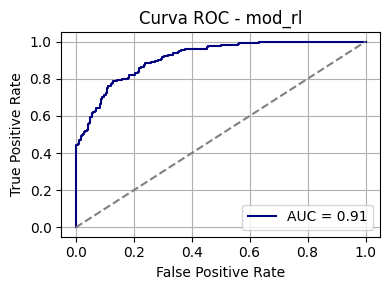

In [50]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='navy')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - mod_rl")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Curva Precision-Recall

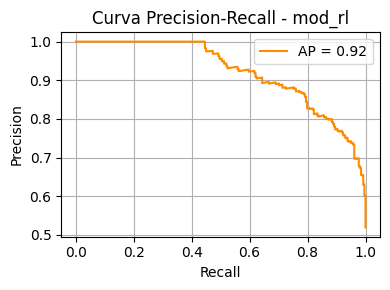

In [56]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(4, 3))
plt.plot(recall, precision, label=f"AP = {ap:.2f}", color='darkorange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - mod_rl")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Matriz de Confusión Anotada

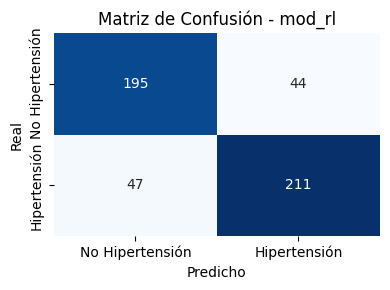

In [57]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=["No Hipertensión", "Hipertensión"],
            yticklabels=["No Hipertensión", "Hipertensión"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - mod_rl")
plt.tight_layout()
plt.show()

### Curva de Calibración

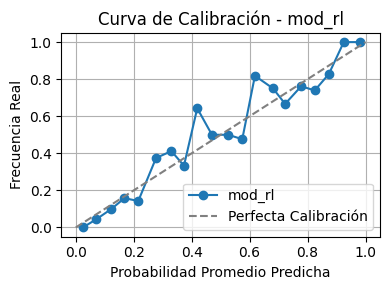

In [67]:
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=20)

plt.figure(figsize=(4, 3))
plt.plot(prob_pred, prob_true, marker='o', label="mod_rl")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfecta Calibración")
plt.xlabel("Probabilidad Promedio Predicha")
plt.ylabel("Frecuencia Real")
plt.title("Curva de Calibración - mod_rl")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Gráfico de Métricas vs Umbral de Decisión

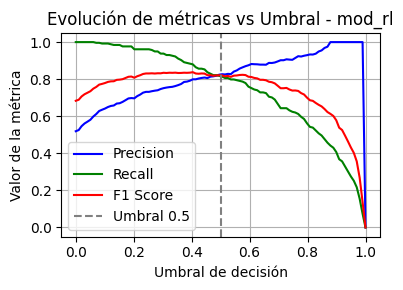

In [72]:
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    preds = (y_proba >= thresh).astype(int)
    precisions.append(precision_score(y_test, preds, zero_division=0))
    recalls.append(recall_score(y_test, preds, zero_division=0))
    f1s.append(f1_score(y_test, preds, zero_division=0))

plt.figure(figsize=(4, 3))
plt.plot(thresholds, precisions, label="Precision", color='blue')
plt.plot(thresholds, recalls, label="Recall", color='green')
plt.plot(thresholds, f1s, label="F1 Score", color='red')
plt.axvline(0.5, linestyle='--', color='gray', label="Umbral 0.5")
plt.xlabel("Umbral de decisión")
plt.ylabel("Valor de la métrica")
plt.title("Evolución de métricas vs Umbral - mod_rl")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Interpretación del Modelo Final**

In [164]:
coeficientes = pd.Series(mod_rl.coef_[0], index=X_train.columns)
odds_ratios = np.exp(coeficientes)

resultado = pd.DataFrame({
    'Coeficiente (log-odds)': coeficientes.round(4),
    'Odds Ratio': odds_ratios.round(4)
})

resultado.sort_values('Odds Ratio', ascending=False)

,Coeficiente (log-odds),Odds Ratio
Smoking_Status,1.9936,7.3421
BP_History,1.9749,7.2062
Family_History,1.9032,6.7073
Stress_Score,1.5371,4.6509
Age,1.4423,4.2306
BMI,0.7136,2.0413
Salt_Intake,0.6647,1.9439
Medication_Diuretic,0.2459,1.2787
Exercise_Level,0.0995,1.1046
Medication_Not specified,0.0024,1.0024


* **Variables con fuerte asociación positiva (riesgo elevado)**

    | Variable                                    | Odds Ratio | Interpretación                                                                                                                               |
    | ------------------------------------------- | ---------- | -------------------------------------------------------------------------------------------------------------------------------------------- |
    | **Smoking\_Status** (fumador)               | **7.34**   | Los individuos fumadores tienen odds de hipertensión **7.3 veces mayores** que los no fumadores. Es el predictor más fuerte del modelo.      |
    | **BP\_History** (historial de presión alta) | **7.21**   | Tener historial de presión alta multiplica por **7.2** las probabilidades de tener hipertensión actualmente.                                 |
    | **Family\_History** (historial familiar)    | **6.71**   | Tener antecedentes familiares de hipertensión **multiplica por 6.7** los odds de padecerla.                                                  |
    | **Stress\_Score**                           | **4.65**   | Cada punto adicional en el puntaje de estrés **multiplica por 4.65** los odds de hipertensión.                                               |
    | **Age**                                     | **4.23**   | Cada unidad adicional de edad (probablemente años) **multiplica por 4.2** los odds. Esto indica un efecto fuertemente creciente con la edad. |
    | **BMI**                                     | **2.04**   | Cada unidad adicional en el índice de masa corporal **duplica** el riesgo. Muestra la relación entre obesidad y presión alta.                |
    | **Salt\_Intake**                            | **1.94**   | Cada unidad adicional de ingesta de sal **casi duplica** los odds de hipertensión.                                                           |

* **Variables con efecto positivo leve**
    
    | Variable                 | Odds Ratio | Interpretación                                                                                                                                                       |
    | ------------------------ | ---------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
    | **Medication\_Diuretic** | **1.28**   | Tomar diuréticos está asociado con un aumento moderado (28%) en los odds de hipertensión. Puede reflejar que son recetados a quienes ya la padecen.                  |
    | **Exercise\_Level**      | **1.10**   | A mayor nivel de ejercicio, hay un **leve aumento** en los odds, lo cual podría ser contradictorio, pero también podría reflejar ejercicio posterior al diagnóstico. |


* **Variables con efecto casi neutro**

    | Variable                      | Odds Ratio | Interpretación                                                          |
    | ----------------------------- | ---------- | ----------------------------------------------------------------------- |
    | **Medication\_Not specified** | **1.002**  | Efecto prácticamente nulo. No hay evidencia de que influya en los odds. |

* **Variables con efecto protector (odds ratio < 1)**

    | Variable                     | Odds Ratio | Interpretación                                                                                                                                          |
    | ---------------------------- | ---------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- |
    | **Medication\_Other**        | **0.92**   | Ligera reducción del riesgo en quienes usan esta clase de medicamentos (odds 8% menores).                                                               |
    | **Medication\_Beta Blocker** | **0.88**   | Uso de beta bloqueadores se asocia con una **reducción del 12%** en los odds de hipertensión. Posible efecto terapéutico.                               |
    | **Sleep\_Duration**          | **0.47**   | Por cada unidad de aumento en la duración del sueño, los odds se **reducen a menos de la mitad**. Es el único predictor con un fuerte efecto protector. |

**Conclusión General:**

* Variables como fumar, historial de presión alta, antecedentes familiares, estrés, edad y sal son los factores de riesgo más importantes en este modelo.
* Ejercicio y algunos medicamentos tienen efectos débiles o confusos, posiblemente porque las personas cambian su estilo de vida luego del diagnóstico.
* Dormir más se asocia con menor riesgo.

## **Exportación**

In [161]:
joblib.dump(mod_rl, 'mod_rl_hipertension.pkl')

['mod_rl_hipertension.pkl']

## **Versión del Modelo**

In [163]:
version = '0.0.0'